# Preprocessing

In [1]:
import os
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.3'
os.environ['SPARK_VERSION']=spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"
# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,461 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,610 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,696 k

In [2]:
# Import packages
from pyspark.sql import SparkSession
import time
# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

In [3]:
from pyspark import SparkFiles

# Import training data
url = "https://raw.githubusercontent.com/KoBlades/Customer-Churn-Project/refs/heads/main/Sources/train.csv"
spark.sparkContext.addFile(url)
spark_train_df = spark.read.csv(SparkFiles.get("train.csv"), sep=",", header=True)
spark_train_df.show()

+----------+------------------+------------------+----------------+----------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+------------------------+---------------+------------------+----------------------+------+-------------+---------------+----------------+----------+-----+
|AccountAge|    MonthlyCharges|      TotalCharges|SubscriptionType|   PaymentMethod|PaperlessBilling|ContentType|MultiDeviceAccess|DeviceRegistered|ViewingHoursPerWeek|AverageViewingDuration|ContentDownloadsPerMonth|GenrePreference|        UserRating|SupportTicketsPerMonth|Gender|WatchlistSize|ParentalControl|SubtitlesEnabled|CustomerID|Churn|
+----------+------------------+------------------+----------------+----------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+------------------------+---------------+------------------+----------------------+------+-------------+-------------

In [4]:
# Import test data
url = "https://raw.githubusercontent.com/KoBlades/Customer-Churn-Project/refs/heads/main/Sources/test.csv"
spark.sparkContext.addFile(url)
spark_test_df = spark.read.csv(SparkFiles.get("test.csv"), sep=",", header=True)
spark_test_df.show()

+----------+------------------+------------------+----------------+----------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+------------------------+---------------+------------------+----------------------+------+-------------+---------------+----------------+----------+
|AccountAge|    MonthlyCharges|      TotalCharges|SubscriptionType|   PaymentMethod|PaperlessBilling|ContentType|MultiDeviceAccess|DeviceRegistered|ViewingHoursPerWeek|AverageViewingDuration|ContentDownloadsPerMonth|GenrePreference|        UserRating|SupportTicketsPerMonth|Gender|WatchlistSize|ParentalControl|SubtitlesEnabled|CustomerID|
+----------+------------------+------------------+----------------+----------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+------------------------+---------------+------------------+----------------------+------+-------------+---------------+---------

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType

#schema to understand data types
spark_train_df.printSchema()
spark_test_df.printSchema()


root
 |-- AccountAge: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- SubscriptionType: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- ContentType: string (nullable = true)
 |-- MultiDeviceAccess: string (nullable = true)
 |-- DeviceRegistered: string (nullable = true)
 |-- ViewingHoursPerWeek: string (nullable = true)
 |-- AverageViewingDuration: string (nullable = true)
 |-- ContentDownloadsPerMonth: string (nullable = true)
 |-- GenrePreference: string (nullable = true)
 |-- UserRating: string (nullable = true)
 |-- SupportTicketsPerMonth: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- WatchlistSize: string (nullable = true)
 |-- ParentalControl: string (nullable = true)
 |-- SubtitlesEnabled: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Churn: string (nullable = true)

root
 |-- AccountAge

In [6]:
from pyspark.sql import functions as F

# Function to count missing values in each column
def count_missing_values(df):
    return df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

# Count missing values in train DataFrame
print("Missing values in Train DataFrame:")
missing_train = count_missing_values(spark_train_df)
missing_train.show()

# Count missing values in test DataFrame
print("Missing values in Test DataFrame:")
missing_test = count_missing_values(spark_test_df)
missing_test.show()


Missing values in Train DataFrame:
+----------+--------------+------------+----------------+-------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+------------------------+---------------+----------+----------------------+------+-------------+---------------+----------------+----------+-----+
|AccountAge|MonthlyCharges|TotalCharges|SubscriptionType|PaymentMethod|PaperlessBilling|ContentType|MultiDeviceAccess|DeviceRegistered|ViewingHoursPerWeek|AverageViewingDuration|ContentDownloadsPerMonth|GenrePreference|UserRating|SupportTicketsPerMonth|Gender|WatchlistSize|ParentalControl|SubtitlesEnabled|CustomerID|Churn|
+----------+--------------+------------+----------------+-------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+------------------------+---------------+----------+----------------------+------+-------------+---------------+----------------+--------

In [7]:
# Count the number of duplicate rows
train_duplicates = spark_train_df.count() - spark_train_df.dropDuplicates().count()
test_duplicates = spark_test_df.count() - spark_test_df.dropDuplicates().count()

print(f"Number of duplicate rows in Train DataFrame: {train_duplicates}")
print(f"Number of duplicate rows in Test DataFrame: {test_duplicates}")



Number of duplicate rows in Train DataFrame: 0
Number of duplicate rows in Test DataFrame: 0


In [8]:
#standardize column names
def standardize_column_names(df):
    # Convert column names to lowercase and replace spaces with underscores
    for col_name in df.columns:
        new_name = col_name.lower().replace(" ", "_")
        df = df.withColumnRenamed(col_name, new_name)
    return df

spark_train_df = standardize_column_names(spark_train_df)
spark_test_df = standardize_column_names(spark_test_df)

# Print the updated column names to verify
print("Standardized column names in Train DataFrame:", spark_train_df.columns)
print("Standardized column names in Test DataFrame:", spark_test_df.columns)


Standardized column names in Train DataFrame: ['accountage', 'monthlycharges', 'totalcharges', 'subscriptiontype', 'paymentmethod', 'paperlessbilling', 'contenttype', 'multideviceaccess', 'deviceregistered', 'viewinghoursperweek', 'averageviewingduration', 'contentdownloadspermonth', 'genrepreference', 'userrating', 'supportticketspermonth', 'gender', 'watchlistsize', 'parentalcontrol', 'subtitlesenabled', 'customerid', 'churn']
Standardized column names in Test DataFrame: ['accountage', 'monthlycharges', 'totalcharges', 'subscriptiontype', 'paymentmethod', 'paperlessbilling', 'contenttype', 'multideviceaccess', 'deviceregistered', 'viewinghoursperweek', 'averageviewingduration', 'contentdownloadspermonth', 'genrepreference', 'userrating', 'supportticketspermonth', 'gender', 'watchlistsize', 'parentalcontrol', 'subtitlesenabled', 'customerid']


In [9]:
#summary statistics
print("Summary statistics for Train DataFrame:")
spark_train_df.describe().show()

print("Summary statistics for Test DataFrame:")
spark_test_df.describe().show()


Summary statistics for Train DataFrame:
+-------+------------------+------------------+------------------+----------------+-------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+------------------------+---------------+------------------+----------------------+------+-----------------+---------------+----------------+----------+-------------------+
|summary|        accountage|    monthlycharges|      totalcharges|subscriptiontype|paymentmethod|paperlessbilling|contenttype|multideviceaccess|deviceregistered|viewinghoursperweek|averageviewingduration|contentdownloadspermonth|genrepreference|        userrating|supportticketspermonth|gender|    watchlistsize|parentalcontrol|subtitlesenabled|customerid|              churn|
+-------+------------------+------------------+------------------+----------------+-------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+--

In [10]:
# Display the first few rows of the cleaned Train DataFrame
print("Cleaned Train DataFrame:")
spark_train_df.show(5)

# Display the first few rows of the cleaned Test DataFrame
print("Cleaned Test DataFrame:")
spark_test_df.show(5)


Cleaned Train DataFrame:
+----------+------------------+------------------+----------------+----------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+------------------------+---------------+------------------+----------------------+------+-------------+---------------+----------------+----------+-----+
|accountage|    monthlycharges|      totalcharges|subscriptiontype|   paymentmethod|paperlessbilling|contenttype|multideviceaccess|deviceregistered|viewinghoursperweek|averageviewingduration|contentdownloadspermonth|genrepreference|        userrating|supportticketspermonth|gender|watchlistsize|parentalcontrol|subtitlesenabled|customerid|churn|
+----------+------------------+------------------+----------------+----------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+------------------------+---------------+------------------+----------------------+------+--

In [11]:
#numerical columns to 2 decimal places
def round_numeric_columns(df):
    for col_name, dtype in df.dtypes:
        if dtype in ['double', 'float']:
            df = df.withColumn(col_name, F.round(F.col(col_name), 2))  # Round to 2 decimal places
    return df

# round numbers in DataFrames
spark_train_df = round_numeric_columns(spark_train_df)
spark_test_df = round_numeric_columns(spark_test_df)

# cleaned and rounded DataFrames
print("Cleaned and rounded Train DataFrame:")
spark_train_df.show(5)

print("Cleaned and rounded Test DataFrame:")
spark_test_df.show(5)


Cleaned and rounded Train DataFrame:
+----------+------------------+------------------+----------------+----------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+------------------------+---------------+------------------+----------------------+------+-------------+---------------+----------------+----------+-----+
|accountage|    monthlycharges|      totalcharges|subscriptiontype|   paymentmethod|paperlessbilling|contenttype|multideviceaccess|deviceregistered|viewinghoursperweek|averageviewingduration|contentdownloadspermonth|genrepreference|        userrating|supportticketspermonth|gender|watchlistsize|parentalcontrol|subtitlesenabled|customerid|churn|
+----------+------------------+------------------+----------------+----------------+----------------+-----------+-----------------+----------------+-------------------+----------------------+------------------------+---------------+------------------+--------------------

In [12]:
# Convert specific columns to IntegerType
spark_train_df = spark_train_df.withColumn("accountage", spark_train_df["accountage"].cast(IntegerType()))
spark_train_df = spark_train_df.withColumn("monthlycharges", spark_train_df["monthlycharges"].cast(IntegerType()))
spark_train_df = spark_train_df.withColumn("totalcharges", spark_train_df["totalcharges"].cast(IntegerType()))
spark_train_df = spark_train_df.withColumn("viewinghoursperweek", spark_train_df["viewinghoursperweek"].cast(IntegerType()))
spark_train_df = spark_train_df.withColumn("averageviewingduration", spark_train_df["averageviewingduration"].cast(IntegerType()))
spark_train_df = spark_train_df.withColumn("contentdownloadspermonth", spark_train_df["contentdownloadspermonth"].cast(IntegerType()))
spark_train_df = spark_train_df.withColumn("userrating", spark_train_df["userrating"].cast(IntegerType()))
spark_train_df = spark_train_df.withColumn("supportticketspermonth", spark_train_df["supportticketspermonth"].cast(IntegerType()))
spark_train_df = spark_train_df.withColumn("watchlistsize", spark_train_df["watchlistsize"].cast(IntegerType()))
spark_train_df = spark_train_df.withColumn("churn", spark_train_df["churn"].cast(IntegerType()))

spark_test_df = spark_test_df.withColumn("accountage", spark_test_df["accountage"].cast(IntegerType()))
spark_test_df = spark_test_df.withColumn("monthlycharges", spark_test_df["monthlycharges"].cast(IntegerType()))
spark_test_df = spark_test_df.withColumn("totalcharges", spark_test_df["totalcharges"].cast(IntegerType()))
spark_test_df = spark_test_df.withColumn("viewinghoursperweek", spark_test_df["viewinghoursperweek"].cast(IntegerType()))
spark_test_df = spark_test_df.withColumn("averageviewingduration", spark_test_df["averageviewingduration"].cast(IntegerType()))
spark_test_df = spark_test_df.withColumn("contentdownloadspermonth", spark_test_df["contentdownloadspermonth"].cast(IntegerType()))
spark_test_df = spark_test_df.withColumn("userrating", spark_test_df["userrating"].cast(IntegerType()))
spark_test_df = spark_test_df.withColumn("supportticketspermonth", spark_test_df["supportticketspermonth"].cast(IntegerType()))
spark_test_df = spark_test_df.withColumn("watchlistsize", spark_test_df["watchlistsize"].cast(IntegerType()))

# Print the updated schema to verify
print("Updated Train DataFrame schema:")
spark_train_df.printSchema()

print("Updated Test DataFrame schema:")
spark_test_df.printSchema()

Updated Train DataFrame schema:
root
 |-- accountage: integer (nullable = true)
 |-- monthlycharges: integer (nullable = true)
 |-- totalcharges: integer (nullable = true)
 |-- subscriptiontype: string (nullable = true)
 |-- paymentmethod: string (nullable = true)
 |-- paperlessbilling: string (nullable = true)
 |-- contenttype: string (nullable = true)
 |-- multideviceaccess: string (nullable = true)
 |-- deviceregistered: string (nullable = true)
 |-- viewinghoursperweek: integer (nullable = true)
 |-- averageviewingduration: integer (nullable = true)
 |-- contentdownloadspermonth: integer (nullable = true)
 |-- genrepreference: string (nullable = true)
 |-- userrating: integer (nullable = true)
 |-- supportticketspermonth: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- watchlistsize: integer (nullable = true)
 |-- parentalcontrol: string (nullable = true)
 |-- subtitlesenabled: string (nullable = true)
 |-- customerid: string (nullable = true)
 |-- churn: integ

In [13]:
print(f"Number of rows in the training data: {spark_train_df.count()}")
print(f"Number of rows in the test data: {spark_test_df.count()}")

Number of rows in the training data: 243787
Number of rows in the test data: 104480


## Standardize Data

In [14]:
# Declare features and targets
target = ['churn']
num_features = ['accountage','monthlycharges','totalcharges','viewinghoursperweek','averageviewingduration','contentdownloadspermonth','userrating','supportticketspermonth','watchlistsize']
cat_features = ['subscriptiontype','paymentmethod','paperlessbilling','contenttype','multideviceaccess','deviceregistered','genrepreference','gender','parentalcontrol','subtitlesenabled']

In [15]:
# Scale the training data
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Convert Spark DataFrame to Pandas DataFrame for sklearn
pandas_train_df = spark_train_df.toPandas()

# Select only the numeric features that need to be scaled
num_features_train = pandas_train_df[num_features]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
scaled_features_train = scaler.fit_transform(num_features_train)

# Select only the cateogorical features that need to be encoded
cat_features_train = pandas_train_df[cat_features]

# Encode the categorical features
subscriptiontype_dummy = pd.get_dummies(cat_features_train['subscriptiontype'],dtype=int)
paymentmethod_dummy = pd.get_dummies(cat_features_train['paymentmethod'],dtype=int)
paperlessbilling_dummy = pd.get_dummies(cat_features_train['paperlessbilling'],dtype=int)
paperlessbilling_dummy = paperlessbilling_dummy.rename(columns={"No":"paperlessbilling_No","Yes":"paperlessbiling_Yes"})
contenttype_dummy = pd.get_dummies(cat_features_train['contenttype'],dtype=int)
multideviceaccess_dummy = pd.get_dummies(cat_features_train['multideviceaccess'],dtype=int)
multideviceaccess_dummy = multideviceaccess_dummy.rename(columns={"No":"multideviceaccess_No","Yes":"multideviceaccess_Yes"})
deviceregistered_dummy = pd.get_dummies(cat_features_train['deviceregistered'],dtype=int)
genrepreference_dummy = pd.get_dummies(cat_features_train['genrepreference'],dtype=int)
gender_dummy = pd.get_dummies(cat_features_train['gender'],dtype=int)
parentalcontrol_dummy = pd.get_dummies(cat_features_train['parentalcontrol'],dtype=int)
parentalcontrol_dummy = parentalcontrol_dummy.rename(columns={"No":"parentalcontrol_No","Yes":"parentalcontrol_Yes"})
subtitlesenabled_dummy = pd.get_dummies(cat_features_train['subtitlesenabled'],dtype=int)
subtitlesenabled_dummy = subtitlesenabled_dummy.rename(columns={"No":"subtitlesenabled_No","Yes":"subtitlesenabled_Yes"})

# Create a new Pandas DataFrame with the scaled features
scaled_train_df = pd.DataFrame(scaled_features_train, columns=['accountage_scaled', 'monthlycharges_scaled', 'totalcharges_scaled', 'viewinghoursperweek_scaled', 'averageviewingduration_scaled', 'contentdownloadspermonth_scaled', 'userrating_scaled', 'supportticketspermonth_scaled', 'watchlistsize_scaled'])

# Concatenate the scaled features with the original DataFrame
pandas_train_df = pd.concat([subscriptiontype_dummy,paymentmethod_dummy,paperlessbilling_dummy,contenttype_dummy,multideviceaccess_dummy,deviceregistered_dummy,genrepreference_dummy,parentalcontrol_dummy,subtitlesenabled_dummy,scaled_train_df], axis=1)

# Convert the Pandas DataFrame back to a Spark DataFrame
scaled_train_df = spark.createDataFrame(pandas_train_df)

# Show the updated Spark DataFrame with scaled features
scaled_train_df.show()

+-----+-------+--------+-------------+-----------+----------------+------------+-------------------+-------------------+----+------+--------+--------------------+---------------------+--------+------+---+------+------+------+-----+-------+------+------------------+-------------------+-------------------+--------------------+--------------------+---------------------+--------------------+--------------------------+-----------------------------+-------------------------------+-------------------+-----------------------------+--------------------+
|Basic|Premium|Standard|Bank transfer|Credit card|Electronic check|Mailed check|paperlessbilling_No|paperlessbiling_Yes|Both|Movies|TV Shows|multideviceaccess_No|multideviceaccess_Yes|Computer|Mobile| TV|Tablet|Action|Comedy|Drama|Fantasy|Sci-Fi|parentalcontrol_No|parentalcontrol_Yes|subtitlesenabled_No|subtitlesenabled_Yes|   accountage_scaled|monthlycharges_scaled| totalcharges_scaled|viewinghoursperweek_scaled|averageviewingduration_scaled|co

In [16]:
from sklearn.model_selection import train_test_split
# Split the training dataset into smaller training and testing DataFrames to build ML Model
features = pandas_train_df
target = spark_train_df.toPandas()["churn"]

In [17]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(features,target,random_state=78)

In [18]:
# Scale the test data
# Convert Spark DataFrame to Pandas DataFrame for sklearn
pandas_test_df = spark_test_df.toPandas()

# Select only the numeric features that need to be scaled
num_features_test = pandas_test_df[num_features]

# Fit and transform the test data
scaled_features_test = scaler.fit_transform(num_features_test)

# Select only the cateogorical features that need to be encoded
cat_features_test = pandas_test_df[cat_features]

# Encode the categorical features
subscriptiontype_dummy_test = pd.get_dummies(cat_features_test['subscriptiontype'],dtype=int)
paymentmethod_dummy_test = pd.get_dummies(cat_features_test['paymentmethod'],dtype=int)
paperlessbilling_dummy_test = pd.get_dummies(cat_features_test['paperlessbilling'],dtype=int)
paperlessbilling_dummy_test = paperlessbilling_dummy_test.rename(columns={"No":"paperlessbilling_No","Yes":"paperlessbiling_Yes"})
contenttype_dummy_test = pd.get_dummies(cat_features_test['contenttype'],dtype=int)
multideviceaccess_dummy_test = pd.get_dummies(cat_features_test['multideviceaccess'],dtype=int)
multideviceaccess_dummy_test = multideviceaccess_dummy_test.rename(columns={"No":"multideviceaccess_No","Yes":"multideviceaccess_Yes"})
deviceregistered_dummy_test = pd.get_dummies(cat_features_test['deviceregistered'],dtype=int)
genrepreference_dummy_test = pd.get_dummies(cat_features_test['genrepreference'],dtype=int)
gender_dummy_test = pd.get_dummies(cat_features_test['gender'],dtype=int)
parentalcontrol_dummy_test = pd.get_dummies(cat_features_test['parentalcontrol'],dtype=int)
parentalcontrol_dummy_test = parentalcontrol_dummy_test.rename(columns={"No":"parentalcontrol_No","Yes":"parentalcontrol_Yes"})
subtitlesenabled_dummy_test = pd.get_dummies(cat_features_test['subtitlesenabled'],dtype=int)
subtitlesenabled_dummy_test = subtitlesenabled_dummy_test.rename(columns={"No":"subtitlesenabled_No","Yes":"subtitlesenabled_Yes"})

# Create a new Pandas DataFrame with the scaled features
scaled_test_df = pd.DataFrame(scaled_features_test, columns=['accountage_scaled', 'monthlycharges_scaled', 'totalcharges_scaled', 'viewinghoursperweek_scaled', 'averageviewingduration_scaled', 'contentdownloadspermonth_scaled', 'userrating_scaled', 'supportticketspermonth_scaled', 'watchlistsize_scaled'])

# Concatenate the scaled features with the original DataFrame
pandas_test_df = pd.concat([subscriptiontype_dummy_test,paymentmethod_dummy_test,paperlessbilling_dummy_test,contenttype_dummy_test,multideviceaccess_dummy_test,deviceregistered_dummy_test,genrepreference_dummy_test,parentalcontrol_dummy_test,subtitlesenabled_dummy_test,scaled_test_df], axis=1)

# Convert the Pandas DataFrame back to a Spark DataFrame
scaled_test_df = spark.createDataFrame(pandas_test_df)

# Show the updated Spark DataFrame with scaled features
scaled_test_df.show()

+-----+-------+--------+-------------+-----------+----------------+------------+-------------------+-------------------+----+------+--------+--------------------+---------------------+--------+------+---+------+------+------+-----+-------+------+------------------+-------------------+-------------------+--------------------+-------------------+---------------------+--------------------+--------------------------+-----------------------------+-------------------------------+-------------------+-----------------------------+--------------------+
|Basic|Premium|Standard|Bank transfer|Credit card|Electronic check|Mailed check|paperlessbilling_No|paperlessbiling_Yes|Both|Movies|TV Shows|multideviceaccess_No|multideviceaccess_Yes|Computer|Mobile| TV|Tablet|Action|Comedy|Drama|Fantasy|Sci-Fi|parentalcontrol_No|parentalcontrol_Yes|subtitlesenabled_No|subtitlesenabled_Yes|  accountage_scaled|monthlycharges_scaled| totalcharges_scaled|viewinghoursperweek_scaled|averageviewingduration_scaled|cont

# Compile, Train and Evaluate the Model

## Neural Network

In [19]:
# Neural Network
import tensorflow as tf

# Define the model
number_input_features = len(X_train.columns)
hidden_nodes_layer1 =  20
hidden_nodes_layer2 = 20

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
print(nn.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │             740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,181 (4.61 KB)

 Trainable params: 1,181 (4.61 KB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
# Compile the model
nn.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [21]:
# Train the model
fit_model = nn.fit(X_train, y_train, epochs=100)

Epoch 1/100
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8215 - loss: 0.4226
Epoch 2/100
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.8245 - loss: 0.4110
Epoch 3/100
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.8246 - loss: 0.4110
Epoch 4/100
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8238 - loss: 0.4135
Epoch 5/100
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8258 - loss: 0.4099
Epoch 6/100
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.8243 - loss: 0.4116
Epoch 7/100
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.8245 - loss: 0.4111
Epoch 8/100
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8246 - loss: 0.4120
Epoch 9/100
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8248 - loss: 0.4113
Epoch 10/100
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8236 - loss: 0.4124
Epoch 11/100
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8243 - loss: 0.4112
Epoch 12

In [22]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test, y_test, verbose=2)
print(f"Accuracy: {round(model_accuracy*100,2)}%")
print(f"Model Loss: {round(model_loss*100,0)}%")

1905/1905 - 3s - 2ms/step - accuracy: 0.8207 - loss: 0.4186
Accuracy: 82.07%
Model Loss: 42.0%


## Logistic Regression Model

Logistic regression model the likelihood that an instance will belong to a particular class, with results between 0 and 1. [Source](https://www.geeksforgeeks.org/ml-logistic-regression-using-python/)

In [19]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression Model
classifier = LogisticRegression(solver='lbfgs', random_state=1)

# Fit or model using the training data
classifier.fit(X_train, y_train)

# Validate the model using the test data
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.824513235615839
Testing Data Score: 0.8238305412899732


In [20]:
# Predict outcomes for test data
lr_predictions = classifier.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score
# Calculate the accuracy score
acc_score = accuracy_score(y_test, lr_predictions)
print(f"Accuracy score: {round(acc_score*100,2)}%")

Accuracy score: 82.38%


In [22]:
# Print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
print("\nConfusion Matrix:\n")
print(confusion_matrix(lr_predictions,y_test))

# Print classification report
print("\nConfusion Matrix:\n")
print(classification_report(lr_predictions,y_test))


Confusion Matrix:

[[48857  9697]
 [ 1040  1353]]

Confusion Matrix:

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     58554
           1       0.12      0.57      0.20      2393

    accuracy                           0.82     60947
   macro avg       0.55      0.70      0.55     60947
weighted avg       0.95      0.82      0.87     60947



[Resource](https://www.geeksforgeeks.org/understanding-feature-importance-in-logistic-regression-models/) used for additional context on understanding logistic regression and interpreting model. Used for Feature Importance and Recursice Feature Elimination.

In [23]:
import numpy as np
# Coefficients and Odds Ratios
coefficients = classifier.coef_[0]
odds_ratios = np.exp(coefficients)

# Display feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})

print(feature_importance.sort_values(by='Coefficient', ascending=False))

                            Feature  Coefficient  Odds Ratio
28            monthlycharges_scaled     0.281263    1.324802
34    supportticketspermonth_scaled     0.254188    1.289414
35             watchlistsize_scaled     0.062249    1.064227
33                userrating_scaled     0.062121    1.064091
29              totalcharges_scaled     0.040004    1.040815
19                           Comedy     0.001253    1.001254
22                           Sci-Fi     0.001042    1.001043
5                  Electronic check    -0.007055    0.992970
0                             Basic    -0.013692    0.986401
6                      Mailed check    -0.041684    0.959173
9                              Both    -0.075153    0.927602
15                           Mobile    -0.093436    0.910796
20                            Drama    -0.098259    0.906414
14                         Computer    -0.102391    0.902676
17                           Tablet    -0.105035    0.900293
2                       

In [24]:
from sklearn.feature_selection import RFE
# Recursive Feature Elimination (RFE)
rfe_model = LogisticRegression(max_iter=10000, solver='liblinear')
rfe = RFE(rfe_model, n_features_to_select=5)
rfe.fit(X_train, y_train)


rfe_features = X_train.columns[rfe.support_]
print("\nSelected Features by RFE:")
print(rfe_features)


Selected Features by RFE:
Index(['paperlessbilling_No', 'paperlessbiling_Yes', 'multideviceaccess_No',
       'multideviceaccess_Yes', 'accountage_scaled'],
      dtype='object')


### Logistic Regression Model (Fewer Features)

In [25]:
# Smaller set of features
#new_features = ["monthlycharges_scaled","supportticketspermonth_scaled","watchlistsize_scaled","userrating_scaled","totalcharges_scaled","Comedy","Sci-Fi","Drama","Fantasy","Action"]
new_features = ["monthlycharges_scaled","supportticketspermonth_scaled","watchlistsize_scaled","userrating_scaled","totalcharges_scaled"]
X_train_new = X_train[new_features]
X_test_new = X_test[new_features]

In [26]:
# Create a Logistic Regression Model
test_classifier = LogisticRegression(solver='lbfgs', random_state=1)

# Fit or model using the training data
test_classifier.fit(X_train_new, y_train)

# Validate the model using the test data
print(f"Training Data Score: {test_classifier.score(X_train_new, y_train)}")
print(f"Testing Data Score: {test_classifier.score(X_test_new, y_test)}")

Training Data Score: 0.8184150076569678
Testing Data Score: 0.8183831853905853


In [27]:
# Predict outcomes for test data
lr_predictions_new = test_classifier.predict(X_test_new)

In [28]:
# Print confusion matrix
print("\nConfusion Matrix:\n")
print(confusion_matrix(lr_predictions_new,y_test))

# Print classification report
print("\nConfusion Matrix:\n")
print(classification_report(lr_predictions_new,y_test))


Confusion Matrix:

[[49709 10881]
 [  188   169]]

Confusion Matrix:

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     60590
           1       0.02      0.47      0.03       357

    accuracy                           0.82     60947
   macro avg       0.51      0.65      0.46     60947
weighted avg       0.99      0.82      0.89     60947



In [29]:
# Coefficients and Odds Ratios
coefficients_test = test_classifier.coef_[0]
odds_ratios_test = np.exp(coefficients_test)

# Display feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_new.columns,
    'Coefficient': coefficients_test,
    'Odds Ratio': odds_ratios_test
})

print(feature_importance.sort_values(by='Coefficient', ascending=False))

                         Feature  Coefficient  Odds Ratio
0          monthlycharges_scaled     0.513243    1.670700
1  supportticketspermonth_scaled     0.233809    1.263403
3              userrating_scaled     0.057924    1.059634
2           watchlistsize_scaled     0.057399    1.059078
4            totalcharges_scaled    -0.571608    0.564617


In [30]:
print(f"Model intercept: {test_classifier.intercept_}")

Model intercept: [-1.61868815]


logit(p(churn)) = -1.62 + 0.51 monthlycharges_scaled + 0.23 supportticketspermonth_scaled + 0.06 userrating_scaled + 0.06 watchlistsize_scaled - 0.57 totalcharges_scaled

In [31]:
# Use the statsmodel package to get the p-values of the features used in the logistic regression model to ensure they are appropriate
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train_new)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.676126
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:               182840
Model:                          Logit   Df Residuals:                   182835
Method:                           MLE   Df Model:                            4
Date:                Sat, 09 Nov 2024   Pseudo R-squ.:                 -0.4288
Time:                        21:30:34   Log-Likelihood:            -1.2362e+05
converged:                       True   LL-Null:                       -86523.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
monthlycharges_scaled             0.3372      0.006     60.385      0.

## KNN Model

In [36]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Instantiate the model with k=2 neighbors
model_knn = KNeighborsClassifier(n_neighbors=2)

# Train the model
model_knn.fit(X_train, y_train)

# Create predictions
y_pred_knn = model_knn.predict(X_test)

# Print confusion matrix
from sklearn.metrics import confusion_matrix
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_pred_knn,y_test))

# Print classification report
print("\nConfusion Matrix:\n")
print(classification_report(y_pred_knn,y_test))


Confusion Matrix:

[[48176 10109]
 [ 1721   941]]

Confusion Matrix:

              precision    recall  f1-score   support

           0       0.97      0.83      0.89     58285
           1       0.09      0.35      0.14      2662

    accuracy                           0.81     60947
   macro avg       0.53      0.59      0.51     60947
weighted avg       0.93      0.81      0.86     60947



## K Means

In [37]:
# K Means Model
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch

# 1. Use the Elbow Method to determine the optimal number of clusters for K-means
# Create a list to store inertia values and the values of k
inertia = []

# Create a list to set the range of k values to test
k = list(range(1,11))

# Create a for loop where each value of k is evaluated using the K-means algorithm
for i in k:
    model = KMeans(n_clusters = i, random_state = 1)
    model.fit(X_train)
    inertia.append(model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,2.674347e+06
1,2,2.425529e+06
2,3,2.322282e+06
3,4,2.256781e+06
4,5,2.215595e+06


In [38]:
#!pip install panel hvplot
# Plot the DataFrame to identify the optimal value for k
import hvplot.pandas
df_elbow.hvplot.line(
    x="k",
    y="inertia",
    title="Elbow Curve",
    xticks=k
)

:Curve   [k]   (inertia)

In [39]:
# 2. Segment the data with K-means using the optimal number of clusters
# Define the model with optimal number of clusters
model_kmeans = KMeans(n_clusters = 3, random_state = 1)

# Fit the model
model_kmeans.fit(X_train)

# Create predictions
y_pred_kmeans = model_kmeans.predict(X_test)

In [40]:
# Create a copy of the DataFrame
test_df_predict = X_test.copy()

# Add a new column to the DataFrame with the predicted clusters
test_df_predict["cluster"] = y_pred_kmeans


In [41]:
plot_data = test_df_predict[["accountage_scaled","monthlycharges_scaled","totalcharges_scaled","viewinghoursperweek_scaled","averageviewingduration_scaled","contentdownloadspermonth_scaled","userrating_scaled","supportticketspermonth_scaled","watchlistsize_scaled","cluster"]]
plot_data.head()

,accountage_scaled,monthlycharges_scaled,totalcharges_scaled,viewinghoursperweek_scaled,averageviewingduration_scaled,contentdownloadspermonth_scaled,userrating_scaled,supportticketspermonth_scaled,watchlistsize_scaled,cluster
168436,1.047577,0.928322,1.655143,-0.889760,-0.510147,-1.629795,-0.448368,-1.219890,-0.558668,0
150658,0.901741,-0.229429,0.488955,-0.267026,-0.054742,0.173113,-0.448368,1.216976,0.692545,1
203930,0.055891,0.928322,0.523368,0.444671,-1.480359,-1.421767,1.340050,0.520728,-0.002573,0
185097,-0.235781,-1.387181,-0.751791,0.978443,0.994671,-1.144397,1.340050,-0.523643,0.275474,1
161324,-1.723308,1.622973,-1.397974,-1.334570,-0.411146,0.658511,1.340050,-1.219890,-1.253786,2


In [42]:
#!pip install panel hvplot
# 3. Plot Clusters
# Plot the clusters
plot_data.hvplot.scatter(
    x="accountage_scaled",
    y="totalcharges_scaled",
    by="cluster"
)

:NdOverlay   [cluster]
   :Scatter   [accountage_scaled]   (totalcharges_scaled)

## PCA & K Means

In [43]:
# PCA
from sklearn.decomposition import PCA

# Instantiate the PCA instance and declare the number of PCA variables
pca = PCA(n_components=2)

# Fit the PCA model on the transformed credit card DataFrame
churn_pca = pca.fit_transform(X_train)

# Review the first 5 rows of list data
churn_pca[:5]

array([[ 0.71024154,  0.92934949],
       [ 0.63437258,  0.03856883],
       [ 0.64700784,  0.78408719],
       [ 0.60402327, -1.5440055 ],
       [ 0.47729138, -1.2299034 ]])

In [44]:
# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_

array([0.13385967, 0.06874693])

The low explained_variance_ratio means that these new variables are not likely enhancing the model and therefore, do not need to proceed with PCA.

#### K Means (NOT NEEDED)

In [45]:
# Create the PCA DataFrame
churn_pca_df = pd.DataFrame(
    churn_pca,
    columns=["PCA1", "PCA2"]
)

# Review the PCA DataFrame
churn_pca_df.head()

,PCA1,PCA2
0,0.710242,0.929349
1,0.634373,0.038569
2,0.647008,0.784087
3,0.604023,-1.544006
4,0.477291,-1.229903


In [46]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Append the value of the computed inertia from the `inertia_` attribute of teh KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(churn_pca_df)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,541840.328631
1,2,294055.569533
2,3,214938.170955
3,4,167247.223967
4,5,133581.437759


In [47]:
# Plot the Elbow Curve
df_elbow.hvplot.line(
    x="k",
    y="inertia",
    title="Elbow Curve",
    xticks=k
)

:Curve   [k]   (inertia)

In [48]:
# Define the model with 3 clusters
model = KMeans(n_clusters=5, random_state=0)

# Fit the model
model.fit(churn_pca_df)

# Make predictions
k_5 = model.predict(churn_pca_df)

# Create a copy of the PCA DataFrame
churn_pca_predictions_df = churn_pca_df.copy()

# Add a class column with the labels
churn_pca_predictions_df["customer_segments"] = k_5

In [49]:
# Plot the clusters
churn_pca_predictions_df.hvplot.scatter(
    x="PCA1",
    y="PCA2",
    by="customer_segments"
)

Output hidden; open in https://colab.research.google.com to view.

# Test Predictive Model

Test logistic regression model with fewer features on the test data.

In [32]:
# Subset the test data with no target column
features_lr_test = pandas_test_df[new_features]

# Predict outcomes for test data
lr_predictions_test = test_classifier.predict(features_lr_test)

# Add the predictions to the feature dataset
feature_lr_predicted = features_lr_test.copy()
feature_lr_predicted["predicted_churn"] = lr_predictions_test

pred_customers_churn = feature_lr_predicted.loc[feature_lr_predicted["predicted_churn"] == 1]
pred_customers_churn.head()




,monthlycharges_scaled,supportticketspermonth_scaled,watchlistsize_scaled,userrating_scaled,totalcharges_scaled,predicted_churn
194,1.624745,1.213999,1.104874,-0.446835,-1.399182,1
437,1.624745,-0.176489,-0.005608,1.341910,-1.324295,1
445,1.624745,1.561622,0.549633,-1.341208,-0.903772,1
462,1.624745,0.866377,0.410823,-0.446835,-1.099632,1
573,1.393437,1.213999,1.382494,1.341910,-1.186041,1


In [33]:
pred_customers_no_churn = feature_lr_predicted.loc[feature_lr_predicted["predicted_churn"] == 0]
pred_customers_no_churn.head()

,monthlycharges_scaled,supportticketspermonth_scaled,watchlistsize_scaled,userrating_scaled,totalcharges_scaled,predicted_churn
0,1.162128,-0.871734,1.521304,0.447537,-0.131854,0
1,-0.688343,-0.871734,1.382494,-0.446835,0.029443,0
2,0.699510,-0.871734,1.382494,1.341910,-1.291651,0
3,0.699510,-1.566978,1.521304,1.341910,1.158517,0
4,0.005583,0.518755,-1.671331,-0.446835,0.730314,0


In [56]:
# Add the predicted outcomes to a Pandas DataFrame of the original test data
predicted_outcome_df = spark_test_df.toPandas()
predicted_outcome_df["predicted_churn"] = lr_predictions_test
predicted_outcome_df["churn_cat"] = ["no churn" if x == 0 else "churn" for x in predicted_outcome_df["predicted_churn"]]
predicted_outcome_df.head()

,accountage,monthlycharges,totalcharges,subscriptiontype,paymentmethod,paperlessbilling,contenttype,multideviceaccess,deviceregistered,viewinghoursperweek,...,genrepreference,userrating,supportticketspermonth,gender,watchlistsize,parentalcontrol,subtitlesenabled,customerid,predicted_churn,churn_cat
0,38,17,679,Premium,Mailed check,No,TV Shows,No,TV,29,...,Comedy,3,2,Male,23,No,No,O1W6BHP6RM,0,no churn
1,77,9,763,Basic,Electronic check,Yes,TV Shows,No,TV,36,...,Action,2,2,Female,22,Yes,No,LFR4X92X8H,0,no churn
2,5,15,75,Standard,Bank transfer,No,TV Shows,Yes,Computer,7,...,Sci-Fi,4,2,Female,22,No,Yes,QM5GBIYODA,0,no churn
3,88,15,1351,Standard,Electronic check,No,Both,Yes,Tablet,35,...,Comedy,4,0,Female,23,Yes,Yes,D9RXTK2K9F,0,no churn
4,91,12,1128,Standard,Credit card,Yes,TV Shows,Yes,Tablet,23,...,Drama,2,6,Female,0,No,No,ENTCCHR1LR,0,no churn


## Predicted Outcome Data Exploration

In [57]:
# Subset the data into churned customers and non-churned customers
pred_churn_df = predicted_outcome_df.loc[predicted_outcome_df["predicted_churn"] == 1]
pred_no_churn_df = predicted_outcome_df.loc[predicted_outcome_df["predicted_churn"] == 0]

print(f"Number of customers predicted to churn: {len(pred_churn_df)}")
print(f"Number of customers predicted to not churn: {len(pred_no_churn_df)}")

Number of customers predicted to churn: 557
Number of customers predicted to not churn: 103923


### Accountage & Membership Type Exploration

<Axes: xlabel='churn_cat', ylabel='accountage'>

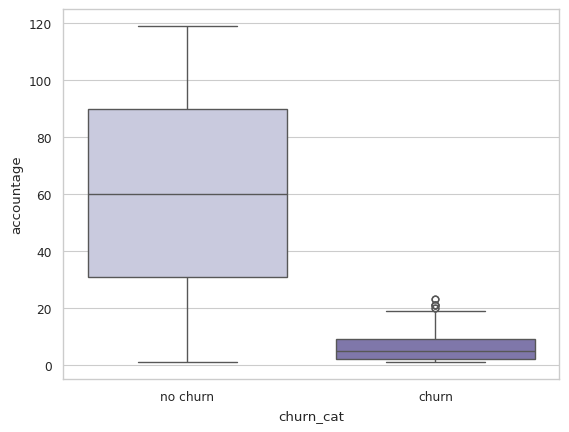

In [58]:
import seaborn

seaborn.set(style="whitegrid")
seaborn.set_context("paper")

seaborn.boxplot(x="churn_cat", y="accountage", hue="churn_cat", data=predicted_outcome_df, palette="Purples")

Text(0, 0.5, 'Account Age')

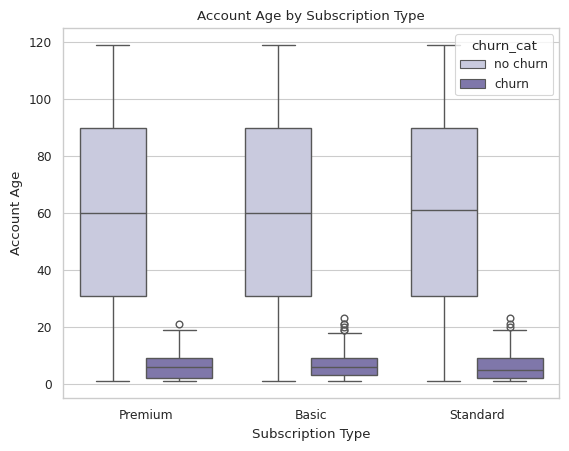

In [59]:
ax = seaborn.boxplot(x="subscriptiontype", y="accountage",
                hue="churn_cat",
                data=predicted_outcome_df, palette="Purples",
                dodge=True)
ax.set_title("Account Age by Subscription Type")
ax.set_xlabel("Subscription Type")
ax.set_ylabel("Account Age")

In [38]:
premium_churned_cc = pred_churn_df.loc[pred_churn_df["subscriptiontype"] == "Premium"]
basic_churned_cc = pred_churn_df.loc[pred_churn_df["subscriptiontype"] == "Basic"]
standard_churned_cc = pred_churn_df.loc[pred_churn_df["subscriptiontype"] == "Standard"]

premium_no_cc = pred_no_churn_df.loc[pred_no_churn_df["subscriptiontype"] == "Premium"]
basic_no_cc = pred_no_churn_df.loc[pred_no_churn_df["subscriptiontype"] == "Basic"]
standard_no_cc = pred_no_churn_df.loc[pred_no_churn_df["subscriptiontype"] == "Standard"]

print(f"Of premium members, the number of customers we expect to churn is {len(premium_churned_cc)} out of {len(premium_churned_cc) + len(premium_no_cc)}; that is {round((len(premium_churned_cc)/(len(premium_churned_cc) + len(premium_no_cc)))*100,2)}%.")
print(f"Of standard members, the number of customers we expect to churn is {len(standard_churned_cc)} out of {len(standard_churned_cc) + len(standard_no_cc)}; that is {round((len(standard_churned_cc)/(len(standard_churned_cc) + len(standard_no_cc)))*100,2)}%.")
print(f"Of basic members, the number of customers we expect to churn is {len(basic_churned_cc)} out of {len(basic_churned_cc) + len(basic_no_cc)}; that is {round((len(basic_churned_cc)/(len(basic_churned_cc) + len(basic_no_cc)))*100,2)}%.")

Of premium members, the number of customers we expect to churn is 150 out of 34691; that is 0.43%.
Of standard members, the number of customers we expect to churn is 214 out of 34833; that is 0.61%.
Of basic members, the number of customers we expect to churn is 193 out of 34956; that is 0.55%.


In [54]:
avg_accountage_churned = pred_churn_df["accountage"].mean()
avg_accountage_no_churned = pred_no_churn_df["accountage"].mean()
print(f"The average account age for customers that are predicted to churn is {round(avg_accountage_churned,2)} months, while those not predicted to churn is {round(avg_accountage_no_churned,2)}.")
avg_acctage_premium_churned = premium_churned_cc["accountage"].mean()
avg_acctage_premium_no_churned = premium_no_cc["accountage"].mean()
print(f"For premium members, the average account age for customers that are predicted to churn is {round(avg_acctage_premium_churned,2)} months, while those not predicted to churn is {round(avg_acctage_premium_no_churned,2)}.")
avg_acctage_standard_churned = standard_churned_cc["accountage"].mean()
avg_acctage_standard_no_churned = standard_no_cc["accountage"].mean()
print(f"For standard members, the average account age for customers that are predicted to churn is {round(avg_acctage_standard_churned,2)} months, while those not predicted to churn is {round(avg_acctage_standard_no_churned,2)}.")
avg_acctage_basic_churned = basic_churned_cc["accountage"].mean()
avg_acctage_basic_no_churned = basic_no_cc["accountage"].mean()
print(f"For basic members, the average account age for customers that are predicted to churn is {round(avg_acctage_basic_churned,2)} months, while those not predicted to churn is {round(avg_acctage_basic_no_churned,2)}.")

The average account age for customers that are predicted to churn is 6.49 months, while those not predicted to churn is 60.35.
For premium members, the average account age for customers that are predicted to churn is 6.39 months, while those not predicted to churn is 60.1.
For standard members, the average account age for customers that are predicted to churn is 6.57 months, while those not predicted to churn is 60.64.
For basic members, the average account age for customers that are predicted to churn is 6.47 months, while those not predicted to churn is 60.31.


### Support Ticket Exploration

Text(0, 0.5, 'Support Tickets per Month')

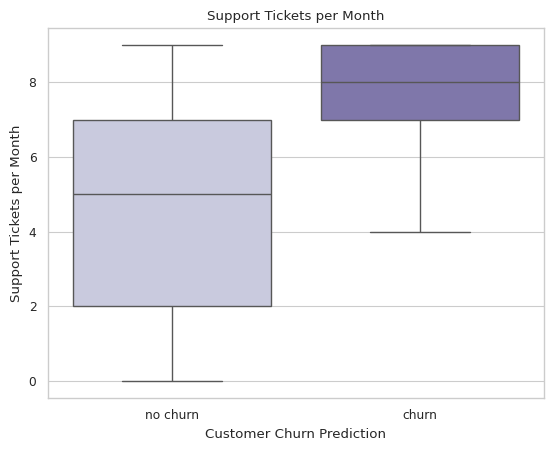

In [61]:
# Box plots of support tickets sent
ax = seaborn.boxplot(x="churn_cat", y="supportticketspermonth", hue="churn_cat", data=predicted_outcome_df, palette="Purples")
ax.set_title("Support Tickets per Month")
ax.set_xlabel("Customer Churn Prediction")
ax.set_ylabel("Support Tickets per Month")

In [41]:
avg_tickets_churned = pred_churn_df["supportticketspermonth"].mean()
avg_tickets_no_churned = pred_no_churn_df["supportticketspermonth"].mean()
print(f"The average number of support tickets sent for customers that are predicted to churn is {round(avg_tickets_churned,2)} months, while those not predicted to churn is {round(avg_tickets_no_churned,2)}.")

The average number of support tickets sent for customers that are predicted to churn is 7.94 months, while those not predicted to churn is 4.49.


This difference is even more concerning when considering that customers that are predicted to churn are sending this many ticket in their first few months of using the platform.

In [42]:
# Conduct ANOVA on the tickets between customers predicted to churn and not churn
from scipy.stats import f_oneway

f_oneway(pred_churn_df[["supportticketspermonth"]], pred_no_churn_df[["supportticketspermonth"]])

F_onewayResult(statistic=array([804.5053287]), pvalue=array([2.65068041e-176]))

After performing a one-way ANOVA to see if there is a difference between the number of support tickets, we would reject the null hypothesis due to a low p-value and conclude that there is a statistically significant difference.

### Genre Preference Exploration

<ipython-input-72-223f4d148c34>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = seaborn.barplot(x=a, y=b, palette="Purples")


Text(0, 0.5, 'Number of Customers')

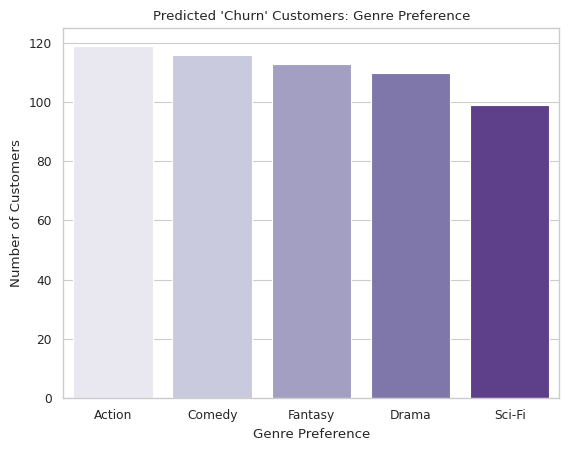

In [72]:
genre_churn_df = pred_churn_df["genrepreference"].value_counts()
a = genre_churn_df.index.values
b = genre_churn_df.values
ax = seaborn.barplot(x=a, y=b, palette="Purples")
ax.set_title("Predicted 'Churn' Customers: Genre Preference")
ax.set_xlabel("Genre Preference")
ax.set_ylabel("Number of Customers")

<ipython-input-73-69186ef4d473>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = seaborn.barplot(x=a, y=b, palette="Purples")


Text(0, 0.5, 'Number of Customers')

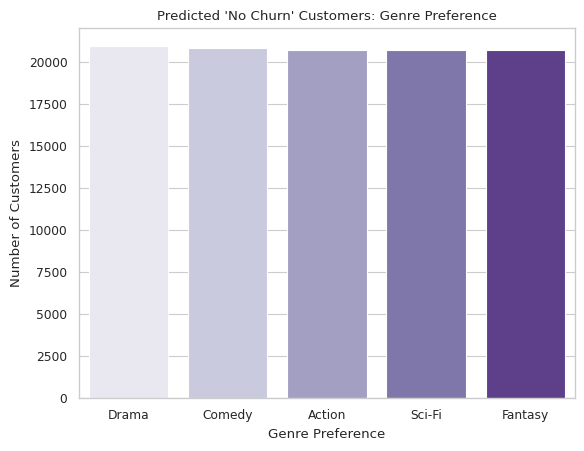

In [73]:
genre_no_churn_df = pred_no_churn_df["genrepreference"].value_counts()
a = genre_no_churn_df.index.values
b = genre_no_churn_df.values
ax = seaborn.barplot(x=a, y=b, palette="Purples")


<Axes: xlabel='genrepreference', ylabel='accountage'>

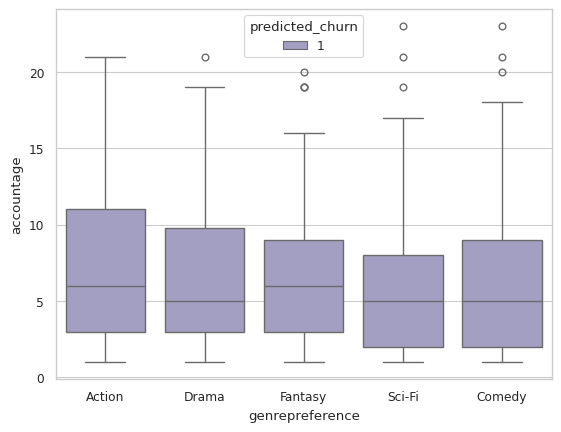

In [45]:
# Box plots of the account age by different genre preferences for customers that are predicted to churn
seaborn.boxplot(x="genrepreference", y="accountage", hue="predicted_churn", data=pred_churn_df, palette="Purples")

In [46]:
f_oneway(pred_churn_df.loc[pred_churn_df["genrepreference"]=="Action","accountage"],
         pred_churn_df.loc[pred_churn_df["genrepreference"]=="Drama","accountage"],
         pred_churn_df.loc[pred_churn_df["genrepreference"]=="Fantasy","accountage"],
         pred_churn_df.loc[pred_churn_df["genrepreference"]=="Sci-Fi","accountage"],
         pred_churn_df.loc[pred_churn_df["genrepreference"]=="Comedy","accountage"])

F_onewayResult(statistic=1.3783209186254348, pvalue=0.2400941715965076)

Based on the results of the one-way ANOVA, we would fail to reject the null hypothesis and conclude that there is no statistical difference between the accountage of different genre preferences for customers that are predicted to churn.

<Axes: xlabel='genrepreference', ylabel='accountage'>

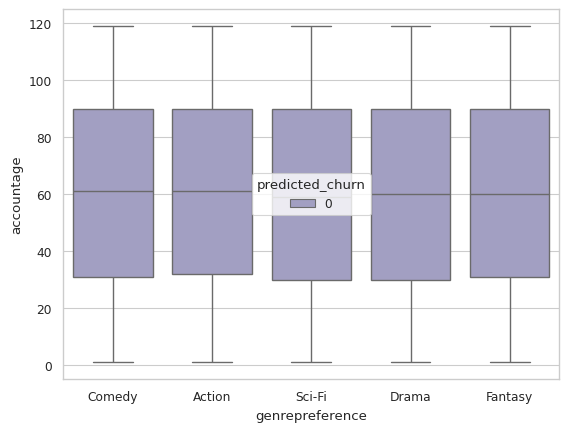

In [47]:
# Box plots of the account age by different genre preferences for customers that are not predicted to churn
seaborn.boxplot(x="genrepreference", y="accountage", hue="predicted_churn", data=pred_no_churn_df, palette="Purples")

### Monthly Charges Exploration

Text(0, 0.5, 'Monthly Subscription Charge')

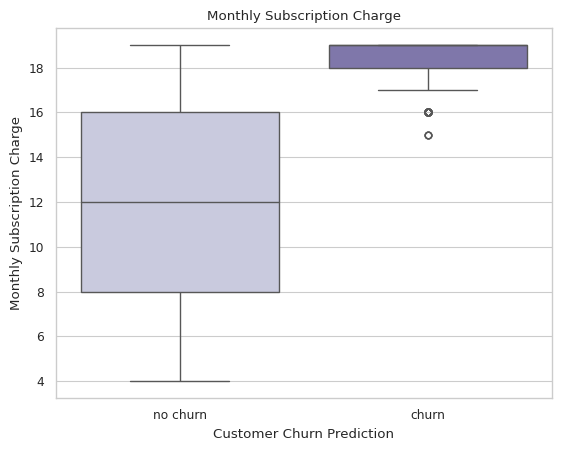

In [64]:
# Box plots of the monthly charges
ax = seaborn.boxplot(x="churn_cat", y="monthlycharges", hue="churn_cat", data=predicted_outcome_df, palette="Purples")
ax.set_title("Monthly Subscription Charge")
ax.set_xlabel("Customer Churn Prediction")
ax.set_ylabel("Monthly Subscription Charge")

In [63]:
avg_monthly_churned = pred_churn_df["monthlycharges"].mean()
avg_monthly_no_churned = pred_no_churn_df["monthlycharges"].mean()

print(f"The average monthly charges for customers that are predicted to churn is ${round(avg_monthly_churned,2)}, while those not predicted to churn is ${round(avg_monthly_no_churned,2)}.")

The average monthly charges for customers that are predicted to churn is $18.25, while those not predicted to churn is $11.94.


In [65]:
# Conduct ANOVA on the monthly charges between customers predicted to churn and not churn
f_oneway(pred_churn_df[["monthlycharges"]], pred_no_churn_df[["monthlycharges"]])

F_onewayResult(statistic=array([1192.69291865]), pvalue=array([6.96505887e-260]))

After performing a one-way ANOVA to see if there is a difference between the monthly subscription fees, we would reject the null hypothesis due to a low p-value and conclude that there is a statistically significant difference.

<Axes: xlabel='supportticketspermonth', ylabel='monthlycharges'>

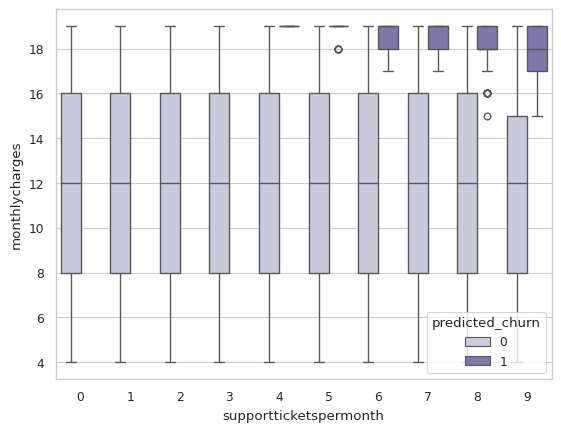

In [52]:
seaborn.boxplot(x="supportticketspermonth", y="monthlycharges", hue="predicted_churn", data=predicted_outcome_df, palette="Purples")

### Other Visuals

<Axes: xlabel='predicted_churn', ylabel='contentdownloadspermonth'>

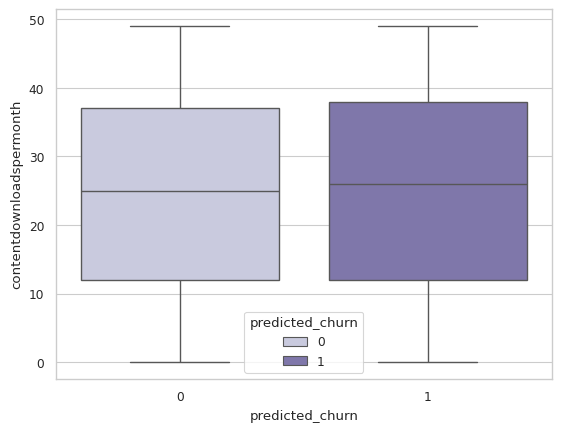

In [50]:
seaborn.boxplot(x="predicted_churn", y="contentdownloadspermonth", hue="predicted_churn", data=predicted_outcome_df, palette="Purples")

In [51]:
avg_downloads_churned = pred_churn_df["contentdownloadspermonth"].mean()
avg_downloads_no_churned = pred_no_churn_df["contentdownloadspermonth"].mean()

print(f"The average number of content downloads per month for customers that are predicted to churn is {round(avg_downloads_churned,2)} months, while those not predicted to churn is {round(avg_downloads_no_churned,2)}.")

The average number of content downloads per month for customers that are predicted to churn is 25.34 months, while those not predicted to churn is 24.45.


After checking the different categorical features against monthlycharges, it is not clear why the churn customers have a higher monthly charge on average.

### Compare customers with same features as those who churn

#### Account Age

In [131]:
aa_df = predicted_outcome_df.loc[predicted_outcome_df["accountage"]<=12]
aa_df.head()

,accountage,monthlycharges,totalcharges,subscriptiontype,paymentmethod,paperlessbilling,contenttype,multideviceaccess,deviceregistered,viewinghoursperweek,...,genrepreference,userrating,supportticketspermonth,gender,watchlistsize,parentalcontrol,subtitlesenabled,customerid,predicted_churn,churn_cat
2,5,15,75,Standard,Bank transfer,No,TV Shows,Yes,Computer,7,...,Sci-Fi,4,2,Female,22,No,Yes,QM5GBIYODA,0,no churn
5,5,19,95,Basic,Electronic check,Yes,Movies,Yes,Tablet,35,...,Comedy,1,1,Male,6,Yes,No,7A88BB5IO6,0,no churn
16,5,13,69,Premium,Credit card,No,Both,No,Mobile,15,...,Comedy,4,9,Male,8,Yes,Yes,QGRPYJC925,0,no churn
26,7,14,99,Standard,Credit card,No,TV Shows,No,Tablet,37,...,Comedy,3,9,Female,4,No,Yes,9WWMDMF8FJ,0,no churn
30,9,18,166,Standard,Bank transfer,Yes,TV Shows,No,Computer,18,...,Drama,1,4,Male,7,No,Yes,QYKZOXQGYZ,0,no churn


In [139]:
len(aa_df.loc[aa_df["predicted_churn"]==0])

9971

In [140]:
len(aa_df.loc[aa_df["predicted_churn"]==1])

480

Text(0, 0.5, 'Support Tickets per Month')

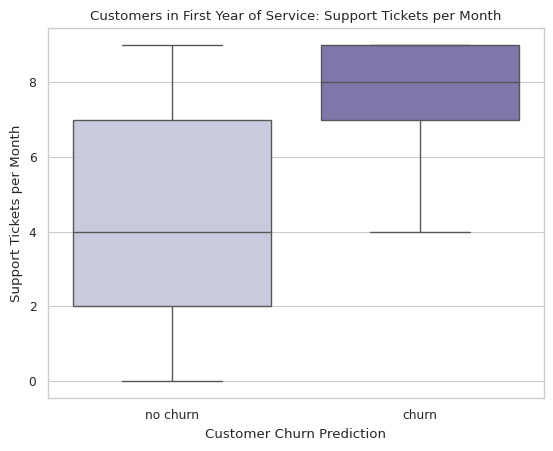

In [132]:
# Box plots of support tickets sent
ax = seaborn.boxplot(x="churn_cat", y="supportticketspermonth", hue="churn_cat", data=aa_df, palette="Purples")
ax.set_title("Customers in First Year of Service: Support Tickets per Month")
ax.set_xlabel("Customer Churn Prediction")
ax.set_ylabel("Support Tickets per Month")

Text(0, 0.5, 'Monthly Subscription Charge')

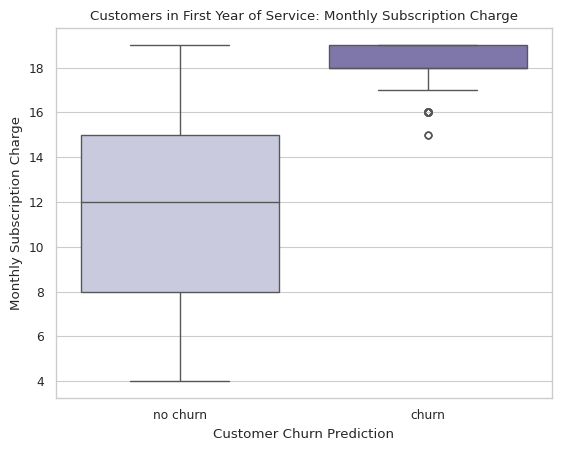

In [133]:
# Box plots of monthly subscription fee
ax = seaborn.boxplot(x="churn_cat", y="monthlycharges", hue="churn_cat", data=aa_df, palette="Purples")
ax.set_title("Customers in First Year of Service: Monthly Subscription Charge")
ax.set_xlabel("Customer Churn Prediction")
ax.set_ylabel("Monthly Subscription Charge")

Text(0, 0.5, 'User Rating')

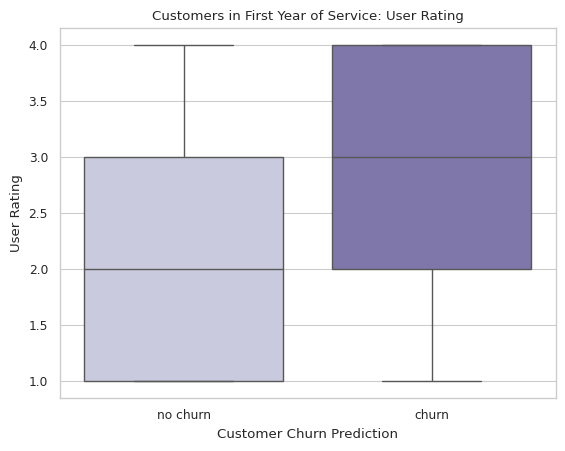

In [134]:
# Box plots of view user rating
ax = seaborn.boxplot(x="churn_cat", y="userrating", hue="churn_cat", data=aa_df, palette="Purples")
ax.set_title("Customers in First Year of Service: User Rating")
ax.set_xlabel("Customer Churn Prediction")
ax.set_ylabel("User Rating")

# Visuals for Initial Training Data

In [67]:
train_df = spark_train_df.toPandas()
train_df["churn_cat"] = ["no churn" if x == 0 else "churn" for x in train_df["churn"]]
train_df.head()

,accountage,monthlycharges,totalcharges,subscriptiontype,paymentmethod,paperlessbilling,contenttype,multideviceaccess,deviceregistered,viewinghoursperweek,...,genrepreference,userrating,supportticketspermonth,gender,watchlistsize,parentalcontrol,subtitlesenabled,customerid,churn,churn_cat
0,20,11,221,Premium,Mailed check,No,Both,No,Mobile,36,...,Sci-Fi,2,4,Male,3,No,No,CB6SXPNVZA,0,no churn
1,57,5,294,Basic,Credit card,Yes,Movies,No,Tablet,32,...,Action,3,8,Male,23,No,Yes,S7R2G87O09,0,no churn
2,73,12,883,Basic,Mailed check,Yes,Movies,No,Computer,7,...,Fantasy,4,6,Male,1,Yes,Yes,EASDC20BDT,0,no churn
3,32,7,232,Basic,Electronic check,No,TV Shows,No,Tablet,27,...,Drama,4,2,Male,24,Yes,Yes,NPF69NT69N,0,no churn
4,57,16,966,Premium,Electronic check,Yes,TV Shows,No,TV,20,...,Comedy,3,4,Female,0,No,No,4LGYPK7VOL,0,no churn


In [85]:
churned_df = train_df.loc[train_df["churn"]==1]
customers_df = train_df.loc[train_df["churn"]==0]

In [87]:
print(f"Churned customers: {len(churned_df)}")
print(f"Percent of customers that have churned: {round(len(churned_df)/len(train_df)*100,2)}%")
print(f"Still customers: {len(customers_df)}")
print(f"Total customers in dataset: {len(train_df)}")

Churned customers: 44182
Percent of customers that have churned: 18.12%
Still customers: 199605
Total customers in dataset: 243787


## Subscription Type

Text(0, 0.5, 'Account Age')

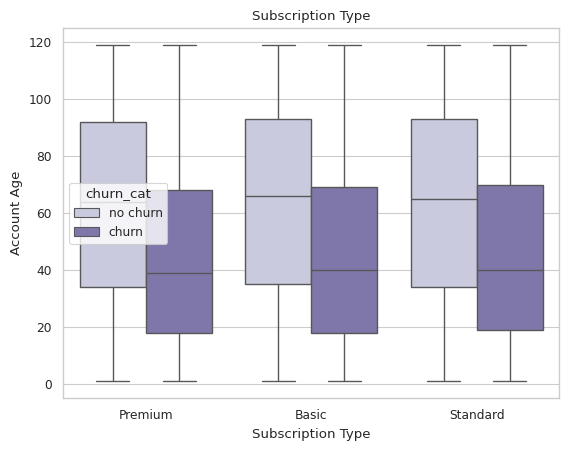

In [88]:
ax = seaborn.boxplot(x="subscriptiontype", y="accountage",
                     hue="churn_cat",
                     data=train_df, palette="Purples",
                     dodge=True)
ax.set_title("Subscription Type")
ax.set_xlabel("Subscription Type")
ax.set_ylabel("Account Age")

In [79]:
premium_df = train_df.loc[train_df["subscriptiontype"]=="Premium"]
basic_df = train_df.loc[train_df["subscriptiontype"]=="Basic"]
standard_df = train_df.loc[train_df["subscriptiontype"]=="Standard"]

avg_age_premium = premium_df["accountage"].mean()
avg_age_basic = basic_df["accountage"].mean()
avg_age_standard = standard_df["accountage"].mean()
print(f"The average account age for premium members is {round(avg_age_premium,2)} months, basic members is {round(avg_age_basic,2)} months, and standard members is {round(avg_age_standard,2)} months.")

The average account age for premium members is 60.02 months, basic members is 60.29 months, and standard members is 59.94 months.


In [102]:
# Conduct ANOVA on the account age between customers predicted to churn and not churn
f_oneway(churned_df[["accountage"]], customers_df[["accountage"]])

F_onewayResult(statistic=array([9919.69637219]), pvalue=array([0.]))

After performing a one-way ANOVA to see if there is a difference between the average account age, we would reject the null hypothesis due to a low p-value and conclude that there is a statistically significant difference.

In [98]:
premium_churn_df = premium_df.loc[premium_df["churn"]==1]
premium_no_churn_df = premium_df.loc[premium_df["churn"]==0]
print(f"average account age for premium members that churned: {round(premium_churn_df['accountage'].mean(),2)}")
print(f"average account age for premium members that did not churn: {round(premium_no_churn_df['accountage'].mean(),2)}")

average account age for premium members that churned: 45.0
average account age for premium members that did not churn: 62.94


In [99]:
basic_churn_df = basic_df.loc[basic_df["churn"]==1]
basic_no_churn_df = basic_df.loc[basic_df["churn"]==0]
print(f"average account age for basic members that churned: {round(basic_churn_df['accountage'].mean(),2)}")
print(f"average account age for basic members that did not churn: {round(basic_no_churn_df['accountage'].mean(),2)}")

average account age for basic members that churned: 46.03
average account age for basic members that did not churn: 63.77


In [100]:
standard_churn_df = standard_df.loc[standard_df["churn"]==1]
standard_no_churn_df = standard_df.loc[standard_df["churn"]==0]
print(f"average account age for standard members that churned: {round(standard_churn_df['accountage'].mean(),2)}")
print(f"average account age for standard members that did not churn: {round(standard_no_churn_df['accountage'].mean(),2)}")

average account age for standard members that churned: 45.88
average account age for standard members that did not churn: 63.12


<ipython-input-76-b69f77a76874>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=a, y=b, palette="Purples")


<Axes: >

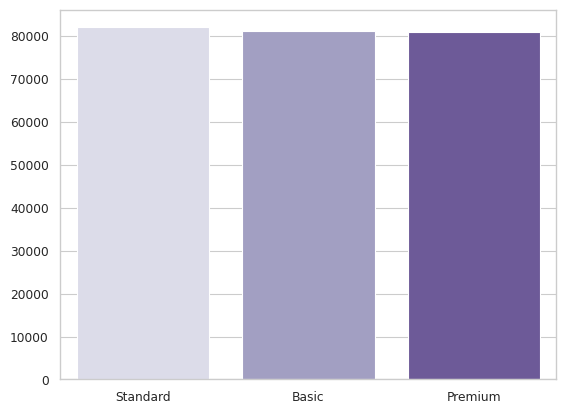

In [76]:
subscriptiontype_df = train_df["subscriptiontype"].value_counts()
a = subscriptiontype_df.index.values
b = subscriptiontype_df.values
ax = seaborn.barplot(x=a, y=b, palette="Purples")
ax.set_title("Predicted 'No Churn' Customers: Genre Preference")
ax.set_xlabel("Genre Preference")
ax.set_ylabel("Number of Customers")

## Content Type

Text(0, 0.5, 'Account Age')

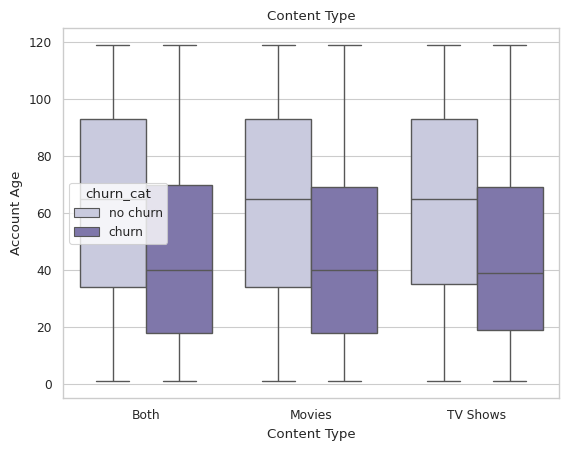

In [104]:
ax = seaborn.boxplot(x="contenttype", y="accountage",
                     hue="churn_cat",
                     data=train_df, palette="Purples",
                     dodge=True)
ax.set_title("Content Type")
ax.set_xlabel("Content Type")
ax.set_ylabel("Account Age")

Text(0, 0.5, 'Viewing Hours per Week')

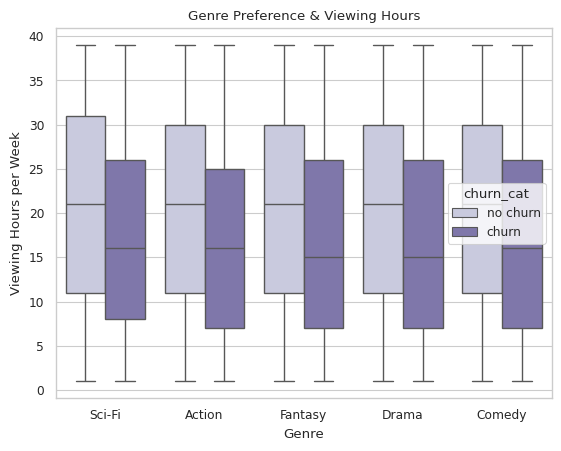

In [106]:
ax = seaborn.boxplot(x="genrepreference", y="viewinghoursperweek",
                     hue="churn_cat",
                     data=train_df, palette="Purples",
                     dodge=True)
ax.set_title("Genre Preference & Viewing Hours")
ax.set_xlabel("Genre")
ax.set_ylabel("Viewing Hours per Week")

## Support Tickets

In [116]:
bins = [0, 1, 3, 6, 9]
labels = ['None', '1-3 tickets', '4-6 tickets', '7+ tickets']
train_df['ticket_cat'] = pd.cut(train_df['supportticketspermonth'], bins=bins, labels=labels)
train_df.head()

,accountage,monthlycharges,totalcharges,subscriptiontype,paymentmethod,paperlessbilling,contenttype,multideviceaccess,deviceregistered,viewinghoursperweek,...,userrating,supportticketspermonth,gender,watchlistsize,parentalcontrol,subtitlesenabled,customerid,churn,churn_cat,ticket_cat
0,20,11,221,Premium,Mailed check,No,Both,No,Mobile,36,...,2,4,Male,3,No,No,CB6SXPNVZA,0,no churn,4-6 tickets
1,57,5,294,Basic,Credit card,Yes,Movies,No,Tablet,32,...,3,8,Male,23,No,Yes,S7R2G87O09,0,no churn,7+ tickets
2,73,12,883,Basic,Mailed check,Yes,Movies,No,Computer,7,...,4,6,Male,1,Yes,Yes,EASDC20BDT,0,no churn,4-6 tickets
3,32,7,232,Basic,Electronic check,No,TV Shows,No,Tablet,27,...,4,2,Male,24,Yes,Yes,NPF69NT69N,0,no churn,1-3 tickets
4,57,16,966,Premium,Electronic check,Yes,TV Shows,No,TV,20,...,3,4,Female,0,No,No,4LGYPK7VOL,0,no churn,4-6 tickets


Text(0, 0.5, 'Viewing Hours per Week')

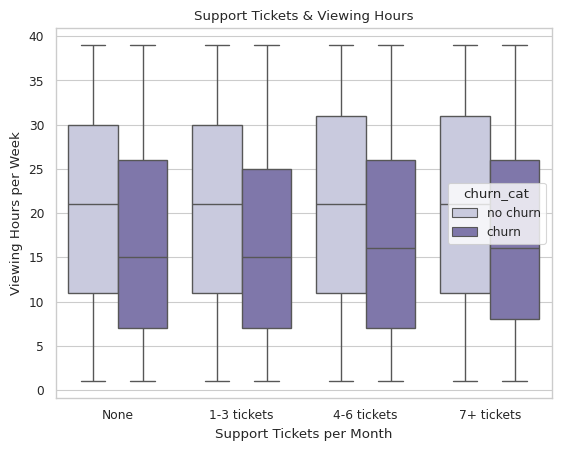

In [117]:
ax = seaborn.boxplot(x="ticket_cat", y="viewinghoursperweek",
                     hue="churn_cat",
                     data=train_df, palette="Purples",
                     dodge=True)
ax.set_title("Support Tickets & Viewing Hours")
ax.set_xlabel("Support Tickets per Month")
ax.set_ylabel("Viewing Hours per Week")

Text(0, 0.5, 'Monthly Subscription Charge')

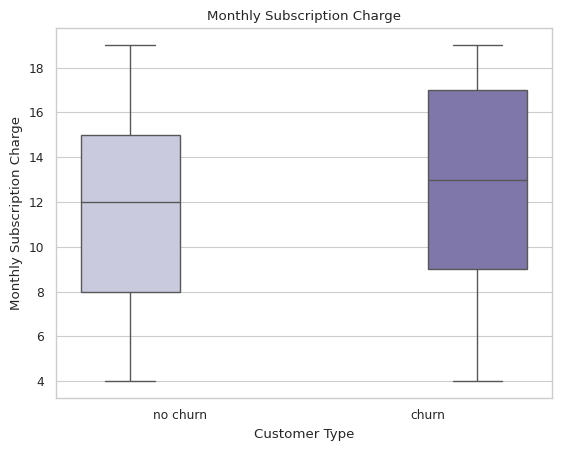

In [118]:
ax = seaborn.boxplot(x="churn_cat", y="monthlycharges",
                     hue="churn_cat",
                     data=train_df, palette="Purples",
                     dodge=True)
ax.set_title("Monthly Subscription Charge")
ax.set_xlabel("Customer Type")
ax.set_ylabel("Monthly Subscription Charge")

In [126]:
round(customers_df[["monthlycharges"]].mean(),2)

,0
monthlycharges,11.79


In [129]:
round(churned_df[["monthlycharges"]].mean(),2)

,0
monthlycharges,12.91


In [130]:
# Conduct ANOVA on the average monthly subscription fee between customers predicted to churn and not churn
f_oneway(churned_df[["monthlycharges"]], customers_df[["monthlycharges"]])

F_onewayResult(statistic=array([2463.32734493]), pvalue=array([0.]))

After performing a one-way ANOVA to see if there is a difference between the average monthly subscription fee, we would reject the null hypothesis due to a low p-value and conclude that there is a statistically significant difference.